In [1]:
# !pip install kneed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import spotipy

from kneed import KneeLocator
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [5]:
kaggle = pd.read_csv('Kaggle Datasets/data.csv')

print(kaggle.shape)
kaggle.head()

(169909, 19)


,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,0,0.708,0.1950,10,-12.428,1,0.0506,0.995,0.563,0.1510,0.7790,118.469,158648,1928,1928
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,0,0.379,0.0135,8,-28.454,1,0.0462,0.994,0.901,0.0763,0.0767,83.972,282133,1928,1928
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.2200,5,-19.924,0,0.9290,0.604,0.000,0.1190,0.8800,107.177,104300,1928,1928
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,0,0.781,0.1300,1,-14.734,0,0.0926,0.995,0.887,0.1110,0.7200,108.003,180760,9/25/1928,1928
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,0,0.210,0.2040,11,-16.829,1,0.0424,0.990,0.908,0.0980,0.0693,62.149,687733,1928,1928


In [6]:
kaggle.columns

Index(['song_id', 'song_name', 'artists', 'popularity', 'explicit',
       'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'release_date', 'year'],
      dtype='object')

In [7]:
# preparing columns for the clusters
kaggle['cluster'] = [-1] * len(kaggle)
kaggle['subcluster'] = [-1] * len(kaggle)

In [8]:
features = ['acousticness','danceability','energy','instrumentalness','liveness', 'loudness','speechiness', 'tempo','valence']

kaggle[features]

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.9950,0.708,0.1950,0.563000,0.1510,-12.428,0.0506,118.469,0.7790
1,0.9940,0.379,0.0135,0.901000,0.0763,-28.454,0.0462,83.972,0.0767
2,0.6040,0.749,0.2200,0.000000,0.1190,-19.924,0.9290,107.177,0.8800
3,0.9950,0.781,0.1300,0.887000,0.1110,-14.734,0.0926,108.003,0.7200
4,0.9900,0.210,0.2040,0.908000,0.0980,-16.829,0.0424,62.149,0.0693
...,...,...,...,...,...,...,...,...,...
169904,0.1730,0.875,0.4430,0.000032,0.0891,-7.461,0.1430,100.012,0.3060
169905,0.0167,0.719,0.3850,0.031300,0.1110,-10.907,0.0403,128.000,0.2700
169906,0.5380,0.514,0.5390,0.002330,0.1080,-9.332,0.1050,123.700,0.1530
169907,0.0714,0.646,0.7610,0.000000,0.2220,-2.557,0.0385,129.916,0.4720


In [9]:
# because the similarity, I'll be focusing just in year.
kaggle[['release_date','year']]

,release_date,year
0,1928,1928
1,1928,1928
2,1928,1928
3,9/25/1928,1928
4,1928,1928
...,...,...
169904,5/15/2020,2020
169905,6/8/2020,2020
169906,5/29/2020,2020
169907,2/28/2020,2020


In [10]:
# Focusing in the relevant metrics (by now)
X = kaggle[['artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
# X = kaggle[['artists', 'popularity', 'explicit','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness',
#             'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms','year']]
X = X.set_index(kaggle['song_id'])
X

,artists,popularity,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
song_id,,,,,,,,,,,,,,,
6KbQ3uYMLKb5jDxLF7wYDD,['Carl Woitschach'],0,0.708,0.1950,10,-12.428,1,0.0506,0.9950,0.563000,0.1510,0.7790,118.469,158648,1928
6KuQTIu1KoTTkLXKrwlLPV,"['Robert Schumann', 'Vladimir Horowitz']",0,0.379,0.0135,8,-28.454,1,0.0462,0.9940,0.901000,0.0763,0.0767,83.972,282133,1928
6L63VW0PibdM1HDSBoqnoM,['Seweryn Goszczyński'],0,0.749,0.2200,5,-19.924,0,0.9290,0.6040,0.000000,0.1190,0.8800,107.177,104300,1928
6M94FkXd15sOAOQYRnWPN8,['Francisco Canaro'],0,0.781,0.1300,1,-14.734,0,0.0926,0.9950,0.887000,0.1110,0.7200,108.003,180760,1928
6N6tiFZ9vLTSOIxkj8qKrd,"['Frédéric Chopin', 'Vladimir Horowitz']",1,0.210,0.2040,11,-16.829,1,0.0424,0.9900,0.908000,0.0980,0.0693,62.149,687733,1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4KppkflX7I3vJQk7urOJaS,"['DripReport', 'Tyga']",75,0.875,0.4430,1,-7.461,1,0.1430,0.1730,0.000032,0.0891,0.3060,100.012,163800,2020
1ehhGlTvjtHo2e4xJFB0SZ,"['Leon Bridges', 'Terrace Martin']",64,0.719,0.3850,8,-10.907,1,0.0403,0.0167,0.031300,0.1110,0.2700,128.000,167468,2020
52eycxprLhK3lPcRLbQiVk,"['Kygo', 'Oh Wonder']",70,0.514,0.5390,7,-9.332,1,0.1050,0.5380,0.002330,0.1080,0.1530,123.700,180700,2020


In [11]:
# I have to code the artists to numbers.

le = LabelEncoder()
trans_artists = le.fit_transform(list(X['artists']))
trans_artists

array([ 4880, 25163, 26351, ..., 16987,  5031, 13224], dtype=int64)

In [12]:
kaggle['coded_artists'] = trans_artists
kaggle.head()

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,0,0.708,0.1950,10,-12.428,1,...,0.563,0.1510,0.7790,118.469,158648,1928,1928,-1,-1,4880
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,0,0.379,0.0135,8,-28.454,1,...,0.901,0.0763,0.0767,83.972,282133,1928,1928,-1,-1,25163
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.2200,5,-19.924,0,...,0.000,0.1190,0.8800,107.177,104300,1928,1928,-1,-1,26351
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,0,0.781,0.1300,1,-14.734,0,...,0.887,0.1110,0.7200,108.003,180760,9/25/1928,1928,-1,-1,9738
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,0,0.210,0.2040,11,-16.829,1,...,0.908,0.0980,0.0693,62.149,687733,1928,1928,-1,-1,10245


In [13]:
X['artists'] = trans_artists
X.head()

,artists,popularity,danceability,energy,song_key,loudness,song_mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,year
song_id,,,,,,,,,,,,,,,
6KbQ3uYMLKb5jDxLF7wYDD,4880,0,0.708,0.1950,10,-12.428,1,0.0506,0.995,0.563,0.1510,0.7790,118.469,158648,1928
6KuQTIu1KoTTkLXKrwlLPV,25163,0,0.379,0.0135,8,-28.454,1,0.0462,0.994,0.901,0.0763,0.0767,83.972,282133,1928
6L63VW0PibdM1HDSBoqnoM,26351,0,0.749,0.2200,5,-19.924,0,0.9290,0.604,0.000,0.1190,0.8800,107.177,104300,1928
6M94FkXd15sOAOQYRnWPN8,9738,0,0.781,0.1300,1,-14.734,0,0.0926,0.995,0.887,0.1110,0.7200,108.003,180760,1928
6N6tiFZ9vLTSOIxkj8qKrd,10245,1,0.210,0.2040,11,-16.829,1,0.0424,0.990,0.908,0.0980,0.0693,62.149,687733,1928


In [14]:
# Now I have to normalize the vectors 

stdscaler = StandardScaler()
X_std = stdscaler.fit_transform(X)
X_std

array([[-1.2417585 , -1.46213535,  0.96866192, ...,  0.04950012,
        -0.59971332, -1.92330144],
       [ 0.85327413, -1.46213535, -0.90763624, ..., -1.07319889,
         0.41811891, -1.92330144],
       [ 0.97598274, -1.46213535,  1.20248631, ..., -0.3179961 ,
        -1.04767984, -1.92330144],
       ...,
       [ 0.00877446,  1.78122556, -0.13772666, ...,  0.21974213,
        -0.41794844,  1.67141853],
       [-1.2261617 ,  1.78122556,  0.61507382, ...,  0.4220408 ,
        -0.52833277,  1.67141853],
       [-0.3799061 ,  1.54955693, -0.14913272, ..., -1.1833306 ,
        -0.13698438,  1.67141853]])

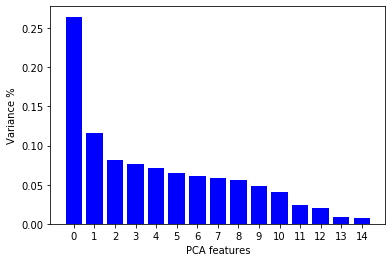

In [15]:
# I'm running PCA first

pca = PCA(n_components=X_std.shape[1])

principal_components = pca.fit_transform(X_std)

# Plot the explained variances

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.xticks(features)

# save components to a dataframe

PCA_components = pd.DataFrame(principal_components)


Text(0, 0.5, 'PCA 2')

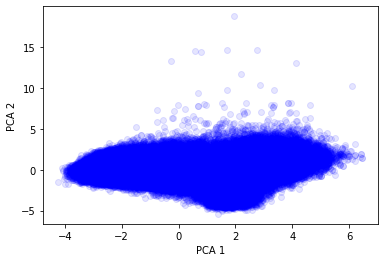

In [16]:
plt.scatter(PCA_components[0],PCA_components[1], alpha=.1, color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

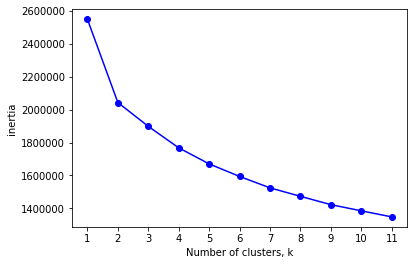

In [17]:
# Find the clusters

ks = range(1,12)
inertias = list()

for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters = k, random_state=42)
    
    # Fit model to samples
    model.fit(X_std)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot the inertias

plt.plot(ks,inertias, '-o', color='blue')
plt.xlabel('Number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [18]:
kl = KneeLocator(range(1,12),inertias, curve='convex',direction='decreasing')
kl.elbow

4

In [19]:
# Defining a function that performs the PCA and clustering, due I'm repeting a couple of times.

def pca_n_clustering(dataset,columns, index_column,max_n_clusters):
    
    # Setting the subset I'm working with
    X = dataset[columns]
    X = X.set_index(dataset[index_column])
    

    # Standarizing the data
    stdscaler = StandardScaler()
    X_std = stdscaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=X_std.shape[1])

    principal_components = pca.fit_transform(X_std)

    # Plot the explained variances

    features = range(pca.n_components_)
       
    plt.bar(features, pca.explained_variance_ratio_, color='blue')
    plt.xlabel('PCA features')
    plt.ylabel('Variance %')
    plt.xticks(features)

    # Save components to a dataframe

    PCA_components = pd.DataFrame(principal_components)
    
    # Plot
#     plt.scatter(PCA_components[0],PCA_components[1], alpha=.1, color='blue')
#     plt.xlabel('PCA 1')
#     plt.ylabel('PCA 2')
    
    # Elbow test
    
    ks = range(1,max_n_clusters)
    inertias = list()

    for k in ks:
        # Create a KMeans instance with k clusters
        model = KMeans(n_clusters = k, random_state=42)

        # Fit model to samples
        model.fit(X_std)

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

#     Plot the inertias

    plt.plot(ks,inertias, '-o', color='blue')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
    kl = KneeLocator(range(1,max_n_clusters),inertias, curve='convex',direction='decreasing')
    print('Suggested number of clusters:',kl.elbow)
    return X_std, le, stdscaler

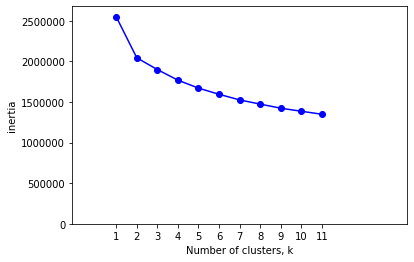

Suggested number of clusters: 4


In [20]:
X_std, le, stdscaler = pca_n_clustering(kaggle,['coded_artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 12)

In [21]:
# I'm going with 4 clusters in a initial stage


# Create a KMeans instance with k clusters
model = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model.fit_predict(X_std)

centers = model.cluster_centers_

labels = model.labels_

labels

array([2, 1, 0, ..., 3, 3, 3])

In [22]:

kaggle['cluster'] = labels
display(kaggle.head())
kaggle.shape

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,0,0.708,0.1950,10,-12.428,1,...,0.563,0.1510,0.7790,118.469,158648,1928,1928,2,-1,4880
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,0,0.379,0.0135,8,-28.454,1,...,0.901,0.0763,0.0767,83.972,282133,1928,1928,1,-1,25163
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.2200,5,-19.924,0,...,0.000,0.1190,0.8800,107.177,104300,1928,1928,0,-1,26351
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,0,0.781,0.1300,1,-14.734,0,...,0.887,0.1110,0.7200,108.003,180760,9/25/1928,1928,2,-1,9738
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,0,0.210,0.2040,11,-16.829,1,...,0.908,0.0980,0.0693,62.149,687733,1928,1928,1,-1,10245


(169909, 22)

In [23]:


cluster_0 =  kaggle[kaggle['cluster'] == 0]
cluster_1 = kaggle[kaggle['cluster'] == 1]
cluster_2 = kaggle[kaggle['cluster'] == 2]
cluster_3 = kaggle[kaggle['cluster'] == 3]

print(cluster_0.shape)
print(cluster_1.shape)
print(cluster_2.shape)
print(cluster_3.shape)


(4499, 22)
(32041, 22)
(47166, 22)
(86203, 22)


In [24]:
# # building a dictionary to store the dataframes

# clustering_dict = {}


In [25]:
# # Define a function that splits the dataframe, according to the subclusters

# def split_dfs(df,k,labels_list,centroids_list,dict_to_use):
    
#     temp_df = df.copy()
#     temp_df['cluster'] = labels_list

#     kaggle_groups = temp_df.groupby(['cluster'])
        
#     dict_to_use['centroids'] = centroids_list
        
#     for i in range(k):

#         if i not in dict_to_use:

#             dict_to_use[i] = {'main':None,'subclusters': dict()}
#         dict_to_use[i]['main'] = kaggle_groups.get_group((i))



In [26]:
# split_dfs(kaggle,4,labels,centers,clustering_dict)
# clustering_dict[0]['main']

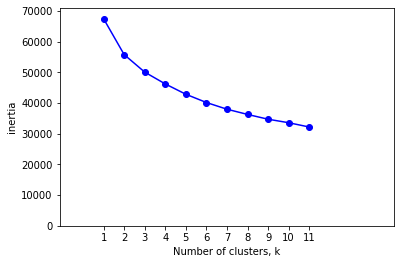

Suggested number of clusters: 4


In [27]:
# For cluster 0:

X_std_0, le_0, stdscaler_0 = pca_n_clustering(cluster_0,['coded_artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 12)

In [28]:
#Create a KMeans instance with k clusters
model_0 = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model_0.fit_predict(X_std_0)

centers_0 = model_0.cluster_centers_

labels_0 = model_0.labels_

kaggle.loc[kaggle[kaggle['cluster'] == 0].index,'subcluster'] = labels_0

# deprecating
# split_dfs(clustering_dict[0]['main'],4,labels_0,centers_0,clustering_dict[0]['subclusters'])

print(kaggle[(kaggle['cluster'] == 0) & (kaggle['subcluster'] == 0)].shape)
print(kaggle[(kaggle['cluster'] == 0) & (kaggle['subcluster'] == 1)].shape)
print(kaggle[(kaggle['cluster'] == 0) & (kaggle['subcluster'] == 2)].shape)
print(kaggle[(kaggle['cluster'] == 0) & (kaggle['subcluster'] == 3)].shape)


(78, 22)
(2508, 22)
(517, 22)
(1396, 22)


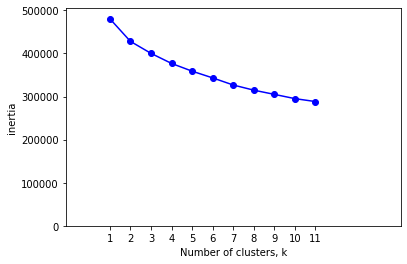

Suggested number of clusters: 4


In [29]:
# For cluster 1:

X_std_1, le_1, stdscaler_1 = pca_n_clustering(cluster_1,['coded_artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 12)

In [30]:
#Create a KMeans instance with k clusters
model_1 = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model_1.fit_predict(X_std_1)

centers_1 = model_1.cluster_centers_

labels_1 = model_1.labels_

kaggle.loc[kaggle[kaggle['cluster'] == 1].index,'subcluster'] = labels_1

# deprecating
# split_dfs(clustering_dict[1]['main'],4,labels_1,centers_1,clustering_dict[1]['subclusters'])

print(kaggle[(kaggle['cluster'] == 1) & (kaggle['subcluster'] == 0)].shape)
print(kaggle[(kaggle['cluster'] == 1) & (kaggle['subcluster'] == 1)].shape)
print(kaggle[(kaggle['cluster'] == 1) & (kaggle['subcluster'] == 2)].shape)
print(kaggle[(kaggle['cluster'] == 1) & (kaggle['subcluster'] == 3)].shape)


(4017, 22)
(13242, 22)
(7379, 22)
(7403, 22)


In [31]:
kaggle.head()

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,instrumentalness,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,0,0.708,0.1950,10,-12.428,1,...,0.563,0.1510,0.7790,118.469,158648,1928,1928,2,-1,4880
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,0,0.379,0.0135,8,-28.454,1,...,0.901,0.0763,0.0767,83.972,282133,1928,1928,1,1,25163
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.2200,5,-19.924,0,...,0.000,0.1190,0.8800,107.177,104300,1928,1928,0,1,26351
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,0,0.781,0.1300,1,-14.734,0,...,0.887,0.1110,0.7200,108.003,180760,9/25/1928,1928,2,-1,9738
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,0,0.210,0.2040,11,-16.829,1,...,0.908,0.0980,0.0693,62.149,687733,1928,1928,1,1,10245


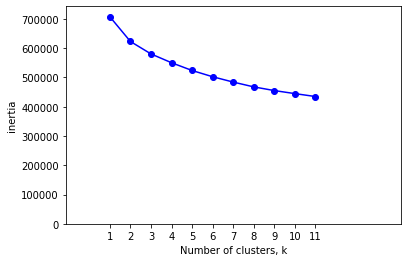

Suggested number of clusters: 4


In [32]:
# For cluster 2:

X_std_2, le_2, stdscaler_2 = pca_n_clustering(cluster_2,['coded_artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 12)

In [33]:
#Create a KMeans instance with k clusters
model_2 = KMeans(n_clusters = 4, random_state=42)

# Fit model to samples
model_2.fit_predict(X_std_2)

centers_2 = model_2.cluster_centers_

labels_2 = model_2.labels_

kaggle.loc[kaggle[kaggle['cluster'] == 2].index,'subcluster'] = labels_2

# deprecating
# split_dfs(clustering_dict[2]['main'],4,labels_2,centers_2,clustering_dict[2]['subclusters'])

print(kaggle[(kaggle['cluster'] == 2) & (kaggle['subcluster'] == 0)].shape)
print(kaggle[(kaggle['cluster'] == 2) & (kaggle['subcluster'] == 1)].shape)
print(kaggle[(kaggle['cluster'] == 2) & (kaggle['subcluster'] == 2)].shape)
print(kaggle[(kaggle['cluster'] == 2) & (kaggle['subcluster'] == 3)].shape)

(14229, 22)
(14792, 22)
(11969, 22)
(6176, 22)


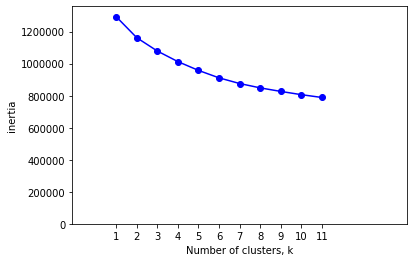

Suggested number of clusters: 5


In [34]:
# For cluster 3:
X_std_3, le_3, stdscaler_3 = pca_n_clustering(cluster_3,['coded_artists', 'popularity', 'danceability', 'energy', 'song_key', 'loudness', 'song_mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year'], 'song_id', 12)

In [35]:
#Create a KMeans instance with k clusters
model_3 = KMeans(n_clusters = 5, random_state=42)

# Fit model to samples
model_3.fit_predict(X_std_3)

centers_3 = model_3.cluster_centers_

labels_3 = model_3.labels_

kaggle.loc[kaggle[kaggle['cluster'] == 3].index,'subcluster'] = labels_3

# deprecating
# split_dfs(clustering_dict[3]['main'],5,labels_3,centers_3,clustering_dict[3]['subclusters'])

print(kaggle[(kaggle['cluster'] == 3) & (kaggle['subcluster'] == 0)].shape)
print(kaggle[(kaggle['cluster'] == 3) & (kaggle['subcluster'] == 1)].shape)
print(kaggle[(kaggle['cluster'] == 3) & (kaggle['subcluster'] == 2)].shape)
print(kaggle[(kaggle['cluster'] == 3) & (kaggle['subcluster'] == 3)].shape)
print(kaggle[(kaggle['cluster'] == 3) & (kaggle['subcluster'] == 4)].shape)

(8885, 22)
(27385, 22)
(16182, 22)
(5635, 22)
(28116, 22)


In [36]:
# Build the similarity dictionary

similarity_dict = {}

In [38]:
# Now I have to measure similarities within subclusters.

limit = 4

for l in range(4):
    
    print('starting with:', l)
    
    if l == 3:
        
        limit = 5
    
    for m in range(limit):

        print('starting with:', m, 'of', l)
        
        demo = kaggle[(kaggle['cluster'] == l) & (kaggle['subcluster'] == m)][['coded_artists','popularity','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
  
        # Standarizing the data
        temp_stdscaler = StandardScaler()
        demo_std = temp_stdscaler.fit_transform(demo)

        demo_std = demo_std / np.linalg.norm(demo_std,axis=1, keepdims=True)


        similarities_array = np.around(demo_std.dot(np.transpose(demo_std)),4)

        song_id_list = list(kaggle[(kaggle['cluster'] == l) & (kaggle['subcluster'] == m)]['song_id'])

        for i, song_id in enumerate(song_id_list):

            if song_id not in similarity_dict:

                similarity_dict[song_id] = {}

            for j, similarity in enumerate(similarities_array[i]):

                if similarity >= 0.75:

                    if similarity not in similarity_dict[song_id]:

                        similarity_dict[song_id][similarity] = []

                    if song_id != song_id_list[j]:
                        
                        similarity_dict[song_id][similarity].append(song_id_list[j])

    print('finishing with:', l)

print(len(similarity_dict.keys()))

starting with: 0
starting with: 0 of 0
starting with: 1 of 0
starting with: 2 of 0
starting with: 3 of 0
finishing with: 0
starting with: 1
starting with: 0 of 1
starting with: 1 of 1
starting with: 2 of 1
starting with: 3 of 1
finishing with: 1
starting with: 2
starting with: 0 of 2
starting with: 1 of 2
starting with: 2 of 2
starting with: 3 of 2
finishing with: 2
starting with: 3
starting with: 0 of 3
starting with: 1 of 3
starting with: 2 of 3
starting with: 3 of 3
starting with: 4 of 3
finishing with: 3
169909


In [39]:
# similarity_dict

In [40]:
similarity_dict['5QrNXvTQEuBb5iLoIAAuvk'].keys()

dict_keys([0.7817, 0.78, 0.7884, 0.798, 0.7835, 0.79, 0.7779, 0.7948, 0.751, 0.8174, 0.7963, 0.8129, 0.7799, 0.763, 0.8626, 0.8181, 0.7531, 0.7682, 0.7751, 0.7767, 0.7516, 0.7563, 0.8724, 0.7999, 0.7742, 0.8193, 0.8214, 0.8245, 0.7939, 0.7936, 0.8234, 0.857, 0.9052, 0.8506, 0.7558, 0.7987, 0.7748, 0.7769, 0.8097, 0.7909, 0.7955, 0.778, 0.8268, 0.8405, 0.777, 0.8239, 0.8166, 0.7995, 0.7856, 0.774, 0.791, 0.8668, 0.8066, 0.7553, 0.7696, 0.909, 0.7979, 0.7867, 0.7503, 0.8397, 0.8759, 0.7812, 0.7775, 0.8156, 0.8134, 0.7954, 0.7535, 0.83, 0.8085, 0.8038, 0.775, 0.8266, 0.7647, 0.8575, 0.8071, 0.766, 0.771, 0.8722, 0.9012, 0.8946, 0.781, 0.8514, 0.8431, 0.7761, 0.7586, 0.8113, 0.799, 0.7655, 0.8674, 0.7805, 0.7913, 0.8173, 0.7827, 0.8717, 0.7888, 0.7918, 0.7648, 0.8145, 0.7672, 0.7564, 0.8274, 0.8338, 0.8016, 0.7743, 0.7857, 0.7942, 0.7524, 0.7781, 0.788, 0.7568, 0.8551, 0.7651, 0.7762, 0.8226, 0.7776, 0.7744, 0.7989, 0.7815, 0.8014, 0.8036, 0.8481, 0.7791, 0.7971, 0.7724, 1.0, 0.7713, 0.773

In [41]:
similarities_list = []
missing_similarities = []

for song_id in kaggle['song_id']:
    
    try:
        
        similarities_list.append(similarity_dict[song_id])
        
    except:
        
        similarities_list.append([])
        missing_similarities.append(song_id)

len(missing_similarities)

0

In [42]:
# something I must take care, are these songs with no similar songs found.
missing_similarities[:10]

[]

In [43]:
kaggle['similar_songs'] = similarities_list

kaggle.head()

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists,similar_songs
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],0,0,0.708,0.1950,10,-12.428,1,...,0.1510,0.7790,118.469,158648,1928,1928,2,3,4880,"{1.0: [], 0.8987: ['6p5vkrnb0SdBxqHXNPn8Zs'], ..."
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",0,0,0.379,0.0135,8,-28.454,1,...,0.0763,0.0767,83.972,282133,1928,1928,1,1,25163,"{1.0: ['2YPbmbRIo7I1r9FAMqNjbZ'], 0.921: ['6Qg..."
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],0,0,0.749,0.2200,5,-19.924,0,...,0.1190,0.8800,107.177,104300,1928,1928,0,1,26351,"{1.0: [], 0.8841: ['7AlZjnh4zKBAfSBVuhJDd4'], ..."
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],0,0,0.781,0.1300,1,-14.734,0,...,0.1110,0.7200,108.003,180760,9/25/1928,1928,2,3,9738,"{1.0: [], 0.8128: ['6TFuAErGpJ9FpxQQ1HC8nM'], ..."
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",1,0,0.210,0.2040,11,-16.829,1,...,0.0980,0.0693,62.149,687733,1928,1928,1,1,10245,"{1.0: [], 0.857: ['4swEz6fT6V3CR0i8BwzRBF'], 0..."


In [44]:
# How the recomendations would be sorted?

# Take this song as an example: 0NlGoUyOJSuSHmngoibVAs

song_looking_for_recommendations = '1SGYSOwGX3PPkJc5ihY2zp'

recommended_songs = []

for list_of_similar in sorted(similarity_dict[song_looking_for_recommendations].keys(), reverse=True)[:11]:
    
    if list_of_similar:
        
        recommended_songs += similarity_dict[song_looking_for_recommendations][list_of_similar]

recommended_songs

['1rD5GoJq7fbw2IEfMCT6S0',
 '69yVorve3CSUgza89ZxLeS',
 '1LXIGfDrobAa9y0kYT9BLJ',
 '2yx6DUrIIGXSAwrvfBrTKQ',
 '2BABTeUx608FA8b47bDuLK',
 '5Yc1rQKy4uv4QJFJTPHEiu',
 '66YHxyGAUGjMBDdrDlWIMD',
 '5aHDLo1MY6y15fWz1BfK2M',
 '2gImbBWvXQWQ9ZDSQUWvNI',
 '1M3xrSPzPcKkCnXGHFPKaw']

In [45]:
# dropping the df to csv to insert it to the db.
# kaggle.to_csv('kaggle_with_recommendations.csv',index=False)

In [46]:
# spotify:track:0HPD5WQqrq7wPWR7P7Dw1i
# spotify:track:4IHiN5A0ythEPmWIKSc7gc
# spotify:track:4lJNen4SMTIJMahALc3DcB

In [47]:
# Now, what should happend when a foreign song to the db comes through, like the song 2PiJrF9Z90OdmTtbbnV2mI.

if not '2PiJrF9Z90OdmTtbbnV2mI' in similarity_dict:
    
    print('The song 2PiJrF9Z90OdmTtbbnV2mI is not in the db.')



The song 2PiJrF9Z90OdmTtbbnV2mI is not in the db.


In [48]:
# With the Spotify API we can get the song features

new_song_id = '1yoMvmasuxZfqHEipJhRbp'

new_song_features = sp.audio_features(new_song_id)[0]
new_song_other_features = sp.track(new_song_id)
# print(new_song_features.keys())
# print(new_song_other_features.keys())

new_song_tf = [new_song_other_features['popularity'],new_song_features['danceability'], new_song_features['energy'], new_song_features['key'], new_song_features['loudness'], new_song_features['mode'],new_song_features['speechiness'], new_song_features['acousticness'], new_song_features['instrumentalness'], new_song_features['liveness'],new_song_features['valence'], new_song_features['tempo'], new_song_features['duration_ms'], int(new_song_other_features['album']['release_date'][:4])]

#### Important: Need to rethink how to handle songs with more than one artist.

new_song_tf = [le.transform([str([new_song_other_features['artists'][0]['name']])])[0]] + new_song_tf
# new_song_tf = [artist_code] + new_song_tf

new_song_tf

[19461,
 89,
 0.783,
 0.727,
 6,
 -3.454,
 0,
 0.389,
 0.185,
 2.46e-05,
 0.0626,
 0.558,
 180.067,
 199112,
 2020]

In [49]:
# First, we have to "prepare" the vector to see in which cluster could be located.
new_song_tf_0 = stdscaler.transform(np.array(new_song_tf).reshape(1,-1))

In [50]:
# In what cluster could be located?
model.predict(np.array(new_song_tf_0).reshape(1,-1))

array([3])

In [51]:
# Now we "prepare" the vector acording to the corresponding cluster scaler.

### Important, not forget to choose the correct scaler

new_song_tf_1 = stdscaler_3.transform(np.array(new_song_tf).reshape(1,-1))

In [52]:
# In what subcluster could be located?

### Important, not forget to choose the correct model

model_3.predict(np.array(new_song_tf_1).reshape(1,-1))


array([0])

In [53]:
# The song's most closet song are: clustering_dict[?]['subclusters'][?]['main']

# So let's find the similarities.

# We have to scale and normalize the subset

comparing_data = kaggle[(kaggle['cluster'] == 3) & (kaggle['subcluster'] == 0)][['coded_artists','popularity','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
comparing_data = stdscaler_3.transform(comparing_data)
comparing_data = comparing_data / np.linalg.norm(comparing_data,axis=1, keepdims=True)
comparing_data

array([[-0.34232347, -0.29681498,  0.32981156, ..., -0.26426391,
        -0.10424285, -0.34749747],
       [-0.1749761 , -0.14588067, -0.18673671, ...,  0.0563489 ,
         0.24173764, -0.15670442],
       [-0.21398358, -0.15968191, -0.06225854, ..., -0.2852653 ,
        -0.0326948 , -0.18623309],
       ...,
       [ 0.31379937,  0.25434132,  0.04442928, ...,  0.29918033,
        -0.1934942 ,  0.31662314],
       [ 0.07772363,  0.34220962,  0.23207473, ..., -0.25796921,
        -0.21414311,  0.38202132],
       [-0.21760719,  0.48819168,  0.41424285, ..., -0.18572362,
        -0.21972888,  0.37209561]])

In [54]:
# Once we know in what subcluster we are, we have to scale the vector
# according to the subcluster, and normalize

### Important, not forget to choose the correct scaler

new_song_tf =  stdscaler_3.transform(np.array(new_song_tf).reshape(1,-1))
new_song_tf = new_song_tf / np.linalg.norm(new_song_tf,axis=1, keepdims=True)
new_song_tf

array([[ 0.03982952,  0.52207698,  0.2019789 ,  0.0428814 ,  0.0322581 ,
         0.23758721, -0.24847654,  0.59670886, -0.01046926, -0.05600442,
        -0.13197372, -0.01185833,  0.3293174 , -0.08764087,  0.26643945]])

In [55]:
# Use cosine length to search for similar songs and their similarities

new_similarities = comparing_data.dot(new_song_tf.T)

new_similarities = [round(arr[0],4) for arr in new_similarities]

new_similarities[:10]

[-0.0354,
 0.1543,
 0.0815,
 0.1516,
 0.0406,
 -0.0708,
 0.1973,
 0.2644,
 0.1503,
 0.227]

In [56]:
len(new_similarities)

8885

In [58]:
similar_songs_new_song = {}

for i, song_id in enumerate(kaggle[(kaggle['cluster'] == 3) & (kaggle['subcluster'] == 0)]['song_id']):
    
    if song_id != new_song_id:
    
        if new_similarities[i] >= 0.75:
            
            if new_similarities[i] not in similar_songs_new_song:
                
                similar_songs_new_song[new_similarities[i]] = []
            similar_songs_new_song[new_similarities[i]].append(song_id)

len(similar_songs_new_song.keys())

587

In [59]:
recommended_songs = []

for list_of_similar in sorted(similar_songs_new_song.keys(), reverse=True)[:11]:
    
    if list_of_similar:
        
        recommended_songs += similar_songs_new_song[list_of_similar]

recommended_songs

['5GpAhJpbHvUi6gY6RG15Ze',
 '56uXDJRCuoS7abX3SkzHKQ',
 '3wLtYwtqvKK2ewelSVPeDK',
 '5nzhL67GpF9szXWg5y509A',
 '1EaKU4dMbesXXd3BrLCtYG',
 '0aQA9DP54h37OevE7hRc2a',
 '2WsuSYJNXGKXVYkHPnq2yp',
 '43mwjiAXLMqkOv4vtlNweU',
 '6LW1weIoMZML7FFTX5fRqv',
 '5MUxrNd7Gr2HksLcAlB0IO',
 '1e4rwBPVI32vZtTJu7mJ4J']

In [83]:
# turning all these last steps into a function

def finding_similar_song_for_new(df,song_id,escaler,cluster_model,new_scalers_list,subcluster_models_list):
    
    # first verify if it is not in the db already.
    
    # If true, pull the similar songs already in the db.
    
    if not df[df['song_id'] == song_id].index.empty:
               
        return df[df['song_id'] == song_id]['similar_songs'].values[0]
    
    # otherwise, Pull the other features from the API
    
    else:
        
        other_features = sp.track(song_id)
        
        # Build the string-list of artists of the song.
        
        artists_list = [] 
        for i in range(len(other_features['artists'])):
            artists_list += [other_features['artists'][i]['name']]

        str_artists_list = str(artists_list)
        
        # Verify if the artist is in the artist catalogue.
        
        if df[df['artists'] == str_artists_list].index.empty:
        
            # if the artist or list of artists is not in the catalogue
            # asign it a number 
            
            code_artist = sorted(kaggle['coded_artists'].unique())[-1] +1
        
        
        else:            
        
            # Find the code for the artist 
        
            code_artist = df[df['artists'] == str_artists_list]['coded_artists'].values[0]
        
        song_features = sp.audio_features(song_id)[0]

        # Find the code for the artist            


        features_vector = [code_artist] + [other_features['popularity'],song_features['danceability'], song_features['energy'], song_features['key'], song_features['loudness'], song_features['mode'],song_features['speechiness'], song_features['acousticness'], song_features['instrumentalness'], song_features['liveness'],song_features['valence'], song_features['tempo'], song_features['duration_ms'], int(other_features['album']['release_date'][:4])]

        scaled_features = stdscaler.transform(np.array(features_vector).reshape(1,-1))

        # Find the number of cluster where it could best fit.

        # In what cluster could it be located?
        cluster_num = cluster_model.predict(np.array(new_song_tf_0).reshape(1,-1))[0]

        # In what subcluster could it be placed?

        new_scaler = new_scalers_list[cluster_num]

        subcluster_model = subcluster_models_list[cluster_num]

        re_scaled_features = new_scaler.transform(np.array(features_vector).reshape(1,-1))

        subcluster_num = subcluster_model.predict(np.array(new_song_tf_0).reshape(1,-1))[0]

        comparing_data = df[(df['cluster'] == cluster_num) & (df['subcluster'] == subcluster_num)][['coded_artists','popularity','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
        comparing_data = new_scaler.transform(comparing_data)
        comparing_data = comparing_data / np.linalg.norm(comparing_data,axis=1, keepdims=True)

        norm_features = re_scaled_features / np.linalg.norm(re_scaled_features,axis=1, keepdims=True)

        new_similarities = comparing_data.dot(norm_features.T)

        new_similarities = [round(arr[0],4) for arr in new_similarities]

        similar_songs = {}

        for i, sng_id in enumerate(df[(df['cluster'] == cluster_num) & (df['subcluster'] == subcluster_num)]['song_id']):

            if sng_id != song_id:

                if new_similarities[i] >= 0.75:

                    if new_similarities[i] not in similar_songs:

                        similar_songs[new_similarities[i]] = []
                    similar_songs[new_similarities[i]].append(sng_id)

        return similar_songs



In [86]:
similar_songs_dict = finding_similar_song_for_new(kaggle,'2lCkncy6bIB0LTMT7kvrD1',stdscaler,model,[stdscaler_0,stdscaler_1,stdscaler_2,stdscaler_3],[model_0,model_1,model_2,model_3])
similar_songs_dict.keys()

dict_keys([0.7811, 0.7719, 0.8026, 0.7754, 0.7809, 0.8908, 0.8164, 0.8118, 0.7791, 0.7556, 0.7765, 0.7528, 0.7828, 0.7545, 0.9163, 0.8527, 0.7647, 0.8393, 0.8345, 0.8484, 0.8308, 0.7883, 0.8336, 0.7551, 0.813, 0.7514, 0.7662, 0.7785, 0.76, 0.8891, 0.8725, 0.782, 0.8124, 0.8099, 0.8109, 0.8829, 0.7503, 0.841, 0.9048, 0.7676, 0.7861, 0.8671, 0.8034, 0.7878, 0.8655, 0.8947, 0.8024, 0.7969, 0.8275, 0.8041, 0.7807, 0.762, 0.775, 0.8142, 0.7981, 0.8011, 0.7758, 0.7694, 0.8407, 0.8322, 0.8066, 0.8155, 0.8569, 0.7558, 0.8432, 0.7866, 0.7636, 0.7554, 0.8699, 0.8915, 0.7661, 0.7853, 0.9137, 0.8187, 0.8199, 0.7627, 0.7679, 0.7611, 0.7598, 0.7842, 0.7858, 0.7688, 0.7752, 0.7998, 0.7774, 0.832, 0.8133, 0.8139, 0.8012, 0.8174, 0.771, 0.7678, 0.8727, 0.8687, 0.8097, 0.7519, 0.7588, 0.8125, 0.9245, 0.7888, 0.7641, 0.7693, 0.773, 0.9184, 0.8995, 0.8459, 0.8203, 0.7695, 0.7787, 0.7508, 0.7607, 0.9178, 0.7804, 0.7822, 0.8437, 0.7703, 0.856, 0.8148, 0.7568, 0.8241, 0.8307, 0.8257, 0.8073, 0.7614, 0.8168, 

In [62]:
def top_10_similar_songs(similar_dictionary):
    
    recommended_songs = []

    for list_of_similar in sorted(similar_dictionary.keys(), reverse=True)[:11]:

        if list_of_similar:

            recommended_songs += similar_dictionary[list_of_similar]

    return recommended_songs

In [87]:
top_10_similar_songs(similar_songs_dict)

['5w9c2J52mkdntKOmRLeM2m',
 '7nKBxz47S9SD79N086fuhn',
 '3mQ6SLdxxaL52Yte7KF2Ks',
 '35KmOEIUqAGn02t7n4qaIr',
 '5bcTCxgc7xVfSaMV3RuVke',
 '7ef4DlsgrMEH11cDZd32M6',
 '3PfIrDoz19wz7qK7tYeu62',
 '3CyCjgTHFzqucmECajq8QA',
 '6WrI0LAC5M1Rw2MnX2ZvEg',
 '5wPhERt9izm1T45aFXDWPe']

# Will continue in another notebook.

# Area 51

In [90]:
kaggle[(kaggle['song_id'] == '3mQ6SLdxxaL52Yte7KF2Ks') | (kaggle['song_id'] == '35KmOEIUqAGn02t7n4qaIr')]

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists,similar_songs
135464,3mQ6SLdxxaL52Yte7KF2Ks,Morado,['J Balvin'],84,0,0.881,0.696,11,-3.838,0,...,0.0927,0.781,97.002,200667,1/9/2020,2020,3,1,13417,"{0.8507: ['3MoV1UsAJmz64LHqyiRMp0'], 0.7522: [..."
161477,35KmOEIUqAGn02t7n4qaIr,Morado,['J Balvin'],81,0,0.885,0.680,11,-3.837,0,...,0.0875,0.780,97.003,200267,3/19/2020,2020,3,1,13417,"{0.8692: ['3MoV1UsAJmz64LHqyiRMp0'], 0.7763: [..."


In [64]:
# clustering_dict[0]['subclusters'][0]['main']

In [65]:
# def build_sim_dict(clust_num,subclust_num,row):
    
#     '''
#     Find the similarity measure based on the angle between the vectors, 
#     and build a dictionary with the cosine of the angle as key.
#     List of songs with the same rounded cosine.
#     '''
    
#     partial_df = clustering_dict[clust_num]['subclusters'][subclust_num]['main'][['popularity','danceability', 'energy', 'song_key', 'loudness', 'song_mode','speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'year']]
#     partial_df.head()

#     # Standarizing the data
#     stdscaler = StandardScaler()
#     partial_df_std = stdscaler.fit_transform(partial_df)

#     partial_df_std = partial_df_std / np.linalg.norm(partial_df_std,axis=1, keepdims=True)  
    
#     similarity_dict = {}
#     for i, _ in enumerate(partial_df.index):

#         similarity = round(partial_df_std.dot(np.transpose(partial_df_std))[row][i],4)


#         if similarity not in similarity_dict:

#             similarity_dict[similarity] = []
            
#         similarity_dict[similarity].append(clustering_dict[clust_num]['subclusters'][subclust_num]['main'].iloc[i,0])

#     return similarity_dict

# build_sim_dict(0,0,0)

In [66]:
# lst_of_sim_dcts = [build_sim_dict(0,0,row) for row in range(len(clustering_dict[0]['subclusters'][0]['main']))]

In [67]:
# # Build a dict with song_id as key
# song_dict = {}

# for i in range(len(clustering_dict.keys())-2):

#     for j in range(len(clustering_dict[i]['subclusters'].keys())-2):

#         lst_of_sim_dcts = [build_sim_dict(i,j,row) for row in range(len(clustering_dict[i]['subclusters'][j]['main']))]

#         for k,id in enumerate(clustering_dict[i]['subclusters'][j]['main']['song_id']):

#             song_dict[id] = lst_of_sim_dcts[k]
            
#         del lst_of_sim_dcts



In [68]:
kaggle[kaggle['artists'] == "['Maluma']"]

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists,similar_songs
15723,1iEwyiSLAunPR6uouANE0O,El Perdedor,['Maluma'],64,0,0.702,0.730,0,-5.173,0,...,0.1480,0.879,173.967,206693,10/30/2015,2015,3,1,19461,"{0.7657: ['4hGOhC87bn7JBdYykOJJvJ'], 0.756: ['..."
15939,62o8KoI44JfN7aYxgTnPvh,Mala Mía,['Maluma'],70,0,0.749,0.752,6,-4.883,1,...,0.2320,0.901,180.049,183753,8/10/2018,2018,3,0,19461,"{0.7636: ['2twGKYnxAYNRQ9z9F3sQ4o', '17Yq72h0p..."
40158,0rIZ49wxDf8H2LXOKmAMW5,Qué Chimba,['Maluma'],74,0,0.725,0.949,7,-3.416,1,...,0.1520,0.581,128.001,169741,3/13/2020,2020,3,1,19461,"{0.7818: ['5XQNN3cHwYRzPv08CHuQNZ', '7qRVyZDt1..."
48001,3wBKCNw7BFIalnqe4VXzdK,ADMV - Versión Urbana,['Maluma'],75,0,0.733,0.591,9,-4.046,1,...,0.0986,0.549,169.905,185263,5/15/2020,2020,3,1,19461,"{0.7867: ['4qjLvvBh5ZeKEPyShKRf06'], 0.7508: [..."
55453,2XVilv6s9GETnw9PG4T9Mz,El Préstamo,['Maluma'],68,0,0.740,0.740,5,-3.647,0,...,0.1070,0.717,93.950,219600,5/18/2018,2018,3,1,19461,"{0.7676: ['0S4RKPbRDA72tvKwVdXQqe'], 0.8015: [..."
70167,1VG7hlZpY73n8h8NgidVTh,Carnaval,['Maluma'],62,0,0.740,0.859,0,-4.742,0,...,0.0639,0.782,130.011,212040,3/6/2015,2015,3,1,19461,"{0.854: ['0Xn1VqBjoL4PAGxyatEO0Z'], 0.7511: ['..."
116616,7KbF6AdprOXEEHlsq11Z6d,11:00 PM,['Maluma'],81,0,0.777,0.712,10,-4.840,1,...,0.0910,0.680,95.692,175733,5/17/2019,2019,3,0,19461,"{0.769: ['6dJJT9h7FzjenIaa31bw8p'], 0.7624: ['..."
125683,6DUdDIRgLqCGq1DwkNWQTN,Borro Cassette,['Maluma'],71,0,0.730,0.701,5,-5.885,0,...,0.1510,0.785,175.950,207307,10/30/2015,2015,3,1,19461,"{0.7899: ['6bLopGnirdrilrpdVB6Um1'], 0.7504: [..."
135309,1RouRzlg8OKFeqc6LvdxmB,Felices los 4,['Maluma'],75,0,0.766,0.756,5,-5.861,1,...,0.3490,0.716,94.027,230000,5/18/2018,2018,3,1,19461,"{0.8532: ['4NmE2ytXI8S2svTRSmEdpO'], 0.7621: [..."
135432,1LIqNVhaIgxXUt2eVoIQJ3,HP,['Maluma'],78,1,0.837,0.791,4,-3.157,0,...,0.1880,0.618,91.980,184436,5/17/2019,2019,3,1,19461,"{0.7551: ['26Q7f4tUntDtlL4EyZz65X'], 0.83: ['4..."


In [69]:
# Hawai - Maluma & The Weekend 
kaggle[kaggle['song_id'] == '0GzuHFG4Ql6DoyxFRnIk3F']

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists,similar_songs


In [70]:
# Hawai - Maluma (Only)
kaggle[kaggle['song_id'] == '1yoMvmasuxZfqHEipJhRbp']

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists,similar_songs


In [71]:
# 11 PM - Maluma 
kaggle[kaggle['song_id'] == '7KbF6AdprOXEEHlsq11Z6d']

,song_id,song_name,artists,popularity,explicit,danceability,energy,song_key,loudness,song_mode,...,liveness,valence,tempo,duration_ms,release_date,year,cluster,subcluster,coded_artists,similar_songs
116616,7KbF6AdprOXEEHlsq11Z6d,11:00 PM,['Maluma'],81,0,0.777,0.712,10,-4.84,1,...,0.091,0.68,95.692,175733,5/17/2019,2019,3,0,19461,"{0.769: ['6dJJT9h7FzjenIaa31bw8p'], 0.7624: ['..."


In [4]:
playlist_id = '5u29iIDT3bBUwusA9Zfq4w'

In [5]:
pl_data = sp.playlist_tracks(playlist_id=playlist_id)

In [7]:
pl_data['items'][99]['track'].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'episode', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track', 'track_number', 'type', 'uri'])

In [31]:
pl_data['items'][99]['track']['preview_url']

In [22]:
track_data = sp.audio_features('10k3RAOXYP96FY4oyp1aQ4')

In [26]:
track_data[0]

{'danceability': 0.462,
 'energy': 0.62,
 'key': 0,
 'loudness': -5.481,
 'mode': 1,
 'speechiness': 0.0331,
 'acousticness': 0.654,
 'instrumentalness': 0,
 'liveness': 0.227,
 'valence': 0.337,
 'tempo': 147.737,
 'type': 'audio_features',
 'id': '10k3RAOXYP96FY4oyp1aQ4',
 'uri': 'spotify:track:10k3RAOXYP96FY4oyp1aQ4',
 'track_href': 'https://api.spotify.com/v1/tracks/10k3RAOXYP96FY4oyp1aQ4',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/10k3RAOXYP96FY4oyp1aQ4',
 'duration_ms': 324587,
 'time_signature': 4}

In [20]:
track_data['artists'][0]['name']

'Camilo Sesto'